In [1]:
import numpy as np
from scipy.linalg import qr
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from PCAalg import *
import time

In [2]:
def generate_data(n_l, d, L, L_out, shared_d=5, latent_d=10, seed=42):
    np.random.seed(seed)

    shared_W = np.random.randn(d, shared_d) * 1
   
    # Generate source-specific transformations (for last 5 latent dimensions)
    source_W = [0. + np.random.randn(d, latent_d - shared_d) * 3 for _ in range(L)]
    out_means = [-2,0.,2] #np.arange(11)/5
    out_sds = [3]
    source_W_out = [np.random.choice(out_means) + 
                    np.random.randn(d, latent_d - shared_d) * np.random.choice(out_sds) 
                    for _ in range(L_out)]

    # Combine to create full transformation matrices for each source
    W_matrices = [np.hstack([shared_W, w]) for w in source_W]
    W_matrices_out = [np.hstack([shared_W, w]) for w in source_W_out]

    
    # Generate data sources
    X_source_list = []
    for l in range(L):
        # Generate latent variables
        latent = np.random.randn(n_l, latent_d)
        
        # Transform to observed space with some noise
        X = (latent @ W_matrices[l].T + np.random.randn(n_l, d) * 0.5)/np.sqrt(d)
        X_source_list.append(X)
    
    X_out_list = []
    for l in range(L_out):
        # Generate latent variables
        latent = np.random.randn(n_l, latent_d)
        # Transform to observed space with some noise
        X_out = (latent @ W_matrices_out[l].T + np.random.randn(n_l, d) * 0.5)/np.sqrt(d)
        X_out_list.append(X_out)
       
    return X_source_list, X_out_list

In [3]:
def pooled_pca_error(X_sources, X_outs, k, center=False):
    """Fit pooled PCA and calculate worst-case reconstruction error"""
    # Pool all data sources
    X_pooled = np.vstack(X_sources)
    
    # Fit PCA on pooled data
    pca = PCA(n_components=k)
    pca.fit(X_pooled)
    
    # Get projection matrix M' = V_k V_k^T where V_k are top k eigenvectors
    V_k = pca.components_.T  # shape (n_features, k)
    M_prime = V_k @ V_k.T
    
    # Calculate reconstruction error for each source
    worst_error = -np.inf
    
    for X in X_sources:
        if center:
            X = X - X.mean(axis=0)
        # Calculate reconstruction error for this source
        reconst = X @ M_prime
        diff = X - reconst
        error = np.mean(np.sum(diff**2, axis=1)) - np.mean(np.sum(X**2, axis=1))
        if error > worst_error:
            worst_error = error
    
    worst_error_out = -np.inf
    for X in X_outs:
        if center:
            X = X - X.mean(axis=0)
        # Calculate reconstruction error for this source
        reconst = X @ M_prime
        diff = X - reconst
        error = np.mean(np.sum(diff**2, axis=1)) - np.mean(np.sum(X**2, axis=1))
        if error > worst_error_out:
            worst_error_out = error
    return worst_error, worst_error_out

def stable_pca_error(X_sources, X_outs, k, center=False):
    stable_pca = StablePCA(n_components=k)
    stable_pca.fit(X_sources, verbose=False)
    M = stable_pca.M
    
    worst_error = -np.inf
    for X in X_sources:
        if center:
            X = X - X.mean(axis=0)
        reconst = X @ M
        diff = X - reconst
        error = np.mean(np.sum(diff**2, axis=1)) - np.mean(np.sum(X**2, axis=1))
        if error > worst_error:
            worst_error = error
            
    worst_error_out = -np.inf
    for X in X_outs:
        if center:
            X = X - X.mean(axis=0)
        reconst = X @ M
        diff = X - reconst
        error = np.mean(np.sum(diff**2, axis=1)) - np.mean(np.sum(X**2, axis=1))
        if error > worst_error_out:
            worst_error_out = error
    return worst_error, worst_error_out

In [11]:
# Parameters
n_l = 1000
d_values = [20, 30, 40, 50, 60, 70, 80, 90, 100]
errors = {d: {'pooled': [], 'stable': []} for d in d_values}
errors_out = {d: {'pooled': [], 'stable': []} for d in d_values}
times = {d: {'pooled': [], 'stable': []} for d in d_values}

np.random.seed(0)
for d in d_values:
  
    for isim in range(10):
        if isim % 10 == 0:
            print(f"Running simulation {isim} for d = {d}")
        L = 4  # number of data sources
        L_out = 100
        k_value = 5

        X_source_list, X_out_list = generate_data(n_l, d, L, L_out, shared_d=5, latent_d=int(d/2), seed=isim)
        start_time_pooled = time.time()
        pooled_worst_error, pooled_worst_error_out = pooled_pca_error(X_source_list, X_out_list, k_value, center=True)
        end_time_pooled = time.time()
        start_time_stable = time.time()
        stable_worst_error, stable_worst_error_out = stable_pca_error(X_source_list, X_out_list, k_value, center=True)
        end_time_stable = time.time()
        errors[d]['pooled'].append(-pooled_worst_error)
        errors[d]['stable'].append(-stable_worst_error)
        errors_out[d]['pooled'].append(-pooled_worst_error_out)
        errors_out[d]['stable'].append(-stable_worst_error_out)
        times[d]['pooled'].append(end_time_pooled - start_time_pooled)
        times[d]['stable'].append(end_time_stable - start_time_stable)

Running simulation 0 for d = 20
Running simulation 0 for d = 30
Running simulation 0 for d = 40
Running simulation 0 for d = 50
Running simulation 0 for d = 60
Running simulation 0 for d = 70
Running simulation 0 for d = 80
Running simulation 0 for d = 90
Running simulation 0 for d = 100


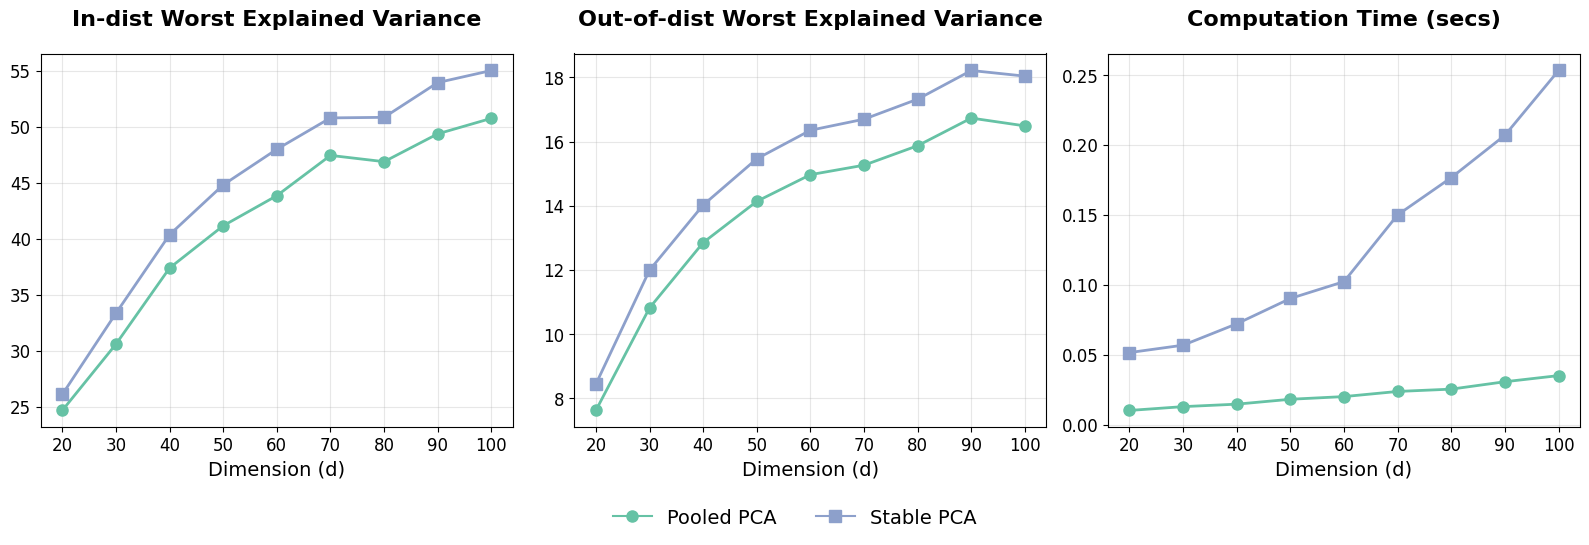

In [13]:
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

# Set global font sizes
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
})

# Create figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
plt.subplots_adjust(bottom=0.25)
# Color setup
set2_colors = ListedColormap(plt.cm.Set2.colors)
colors = [set2_colors(0), set2_colors(2)]

# Calculate means
error_means = {
    'pooled': [np.mean(errors[d]['pooled']) for d in d_values],
    'stable': [np.mean(errors[d]['stable']) for d in d_values]
}
error_out_means = {
    'pooled': [np.mean(errors_out[d]['pooled']) for d in d_values],
    'stable': [np.mean(errors_out[d]['stable']) for d in d_values]
}
time_means = {
    'pooled': [np.mean(times[d]['pooled']) for d in d_values],
    'stable': [np.mean(times[d]['stable']) for d in d_values]
}

# Plot Pooled PCA results
pooled_line = ax1.plot(d_values, error_means['pooled'], '-o', color=colors[0], 
         markersize=8, linewidth=2, label='Pooled PCA')
stable_line = ax1.plot(d_values, error_means['stable'], '-s', color=colors[1], 
         markersize=8, linewidth=2, label='Stable PCA')

ax1.set_xlabel('Dimension (d)', fontsize=14)
# ax1.set_ylabel('Average Worst Explained Variance', fontsize=14)
ax1.set_title('In-dist Worst Explained Variance', fontsize=16, weight='bold', pad=20)
ax1.grid(True, alpha=0.3)

# Plot Pooled PCA results
ax2.plot(d_values, error_out_means['pooled'], '-o', color=colors[0], 
         markersize=8, linewidth=2, label='Pooled PCA')
ax2.plot(d_values, error_out_means['stable'], '-s', color=colors[1], 
         markersize=8, linewidth=2, label='Stable PCA')

ax2.set_xlabel('Dimension (d)', fontsize=14)
# ax1.set_ylabel('Average Worst Explained Variance', fontsize=14)
ax2.set_title('Out-of-dist Worst Explained Variance', fontsize=16, weight='bold', pad=20)
ax2.grid(True, alpha=0.3)

# Plot Pooled PCA times
ax3.plot(d_values, time_means['pooled'], '-o', color=colors[0], 
         markersize=8, linewidth=2, label='Pooled PCA')

# Plot Stable PCA times
ax3.plot(d_values, time_means['stable'], '-s', color=colors[1], 
         markersize=8, linewidth=2, label='Stable PCA')

ax3.set_xlabel('Dimension (d)', fontsize=14)
# ax3.set_ylabel('Average Time (secs)', fontsize=14)
ax3.set_title('Computation Time (secs)', fontsize=16, weight='bold', pad=20)
ax3.grid(True, alpha=0.3)


# Create proxy artists for legend
pooled_proxy = mlines.Line2D([], [], color=colors[0], marker='o', linestyle='-',
                           markersize=8, label='Pooled PCA')
stable_proxy = mlines.Line2D([], [], color=colors[1], marker='s', linestyle='-',
                           markersize=8, label='Stable PCA')

# Create a single legend below both subplots
fig.legend(handles=[pooled_proxy, stable_proxy],
          loc='lower center', 
          ncol=2, 
          frameon=False,
          fontsize=14,
          bbox_to_anchor=(0.5, -0.1))

# Adjust layout to make room for the legend
plt.tight_layout()
plt.savefig('worst_case_comparison.png', bbox_inches='tight')
plt.show()